In [1]:
from IPython.core.display import Image, display
display(Image(url='https://www.greekmythology.com/images/mythology/aegis_228.jpg', width=200, unconfined=True))

/tmp/ipykernel_3746253/4129434108.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


AEGIS: Astrophysical Event Generator for Integration with Simulation-based inference

Make sure you're working with a kernal that has healpy, astropy, and sbi installed.

Let's get started generating some photon maps with an AEGIS object. First, let's import some needed modules.

In [2]:
import aegis
import numpy as np
import healpy as hp
import pickle as pk
from astropy import units as u
from astropy import constants as c
import matplotlib.pyplot as plt
from os import listdir
import os
import sys
from sbi.inference import SNLE, SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from getdist import plots, MCSamples

%matplotlib inline

Now, let's initialize an AEGIS. First, we must define a few parameters that control how the AEGIS will generate sources and photons. If sources have incompatible values for the parameters bellow, simply instantiate multiple AEGIS objects.

In [3]:
parameter_range = [[], []]
abundance_luminosity_and_spectrum_list = []
source_class_list = []
parameter_names = []
energy_range = [2000, 100000] #MeV
energy_range_gen = [energy_range[0]*0.5, energy_range[1]*1.5]
luminosity_range = 10.0**np.array([30, 37])
max_radius = 8.5 + 20*2 #kpc
exposure = 2000*10*0.2 #cm^2 yr
flux_cut = 1e-9 #photons/cm^2/s
angular_cut = np.pi #10*u.deg.to('rad') #degrees
angular_cut_gen = angular_cut*1.5
lat_cut = 0 #2*u.deg.to('rad') #degrees
lat_cut_gen = lat_cut*0.5

In [4]:
my_AEGIS = aegis.aegis(abundance_luminosity_and_spectrum_list, source_class_list, parameter_range, energy_range, luminosity_range, max_radius, exposure, angular_cut, lat_cut, flux_cut, verbose = False)
my_AEGIS.angular_cut_gen, my_AEGIS.lat_cut_gen, my_AEGIS.Emin_gen, my_AEGIS.Emax_gen = angular_cut_gen, lat_cut_gen, energy_range_gen[0], energy_range_gen[1]

Next, let's add a source to the AEGIS.

Sources are generally input as a set of user-defined functions that determine their abundance in space, luminosity, and spectra. These functions are added to a list called the als, which is in turn added to the AEGIS object. There are a few different types of sources we can add to the AEGIS. Each of these will have different requirements for their user-defined als. All functions in the als should accept a list of model parameters as an input. The currently implemented types are described below.

independent_spherical_multi_specta
:
Independent and spherical refer to sources with abundance functions dN/dV of the form R(r, params)Θ(θ, params)Φ(φ, params).
The luminosity function should return the distribution function of luminosities dN/dL and have the form L(l, params).
Multi-spectra refers to this source type having a distribution function for the spectrum of each realization of the source type. So, all of the sources of this type in any given simulation could have different spectra. The spectral function should be of the form S(e, num_spectra, params), which should internally pull from some distribution to produce num_spectra different spectra of the form dN/dE. S should return a numpy array of dimensions (number of spectra)X(number of energy values).
The als of this source type should be of the form [(R, Θ, Φ), L, S].

independent_spherical_sngle_sp
ectrum:
Independent and spherical refer to sources with abundance functions dN/dV of the form R(r, params)Θ(θ, params)Φ(φ, params).
The luminosity function should return the distribution function of luminosities dN/dL and have the form L(l, params).
Single spectrum refers to all realizations of this type having an identical spectrum. The spectral function dN/dE should be of the form S(e, params) and return a numpy array of length (number of energy values).
The als of this source type should be of the form [(R, Θ, Φ), L, S].

independent_cylindrical_multi_spectra:
Independent and cylindrical refer to sources with abundance functions dN/dV of the form R(r, params)Z(z, params)Φ(φ, params).
The luminosity function should return the distribution function of luminosities dN/dL and have the form L(l, params).
Multi-spectra refers to this source type having a distribution function for the spectrum of each realization of the source type. So, all of the sources of this type in any given simulation could have different spectra. The spectral function should be of the form S(e, num_spectra, params), which should internally pull from some distribution to produce num_spectra different spectra of the form dN/dE. S should return a numpy array of dimensions (number of spectra)X(number of energy values).
The als of this source type should be of the form [(R, Z, Φ), L, S].

independent_cylindrical_single_spectrum:
Independent and cylindrical refer to sources with abundance functions dN/dV of the form R(r, params)Z(z, params)Φ(φ, params).
The luminosity function should return the distribution function of luminosities dN/dL and have the form L(l, params).
Single spectrum refers to all realizations of this type having an identical spectrum. The spectral function dN/dE should be of the form S(e, params) and return a numpy array of length (number of energy values).
The als of this source type should be of the form [(R, Z, Φ), L, S].

isotropic_diffuse:
A truly isotropic and diffuse source can be defined by a single spectral function dN/dE of the form S(e, params). This function should be normalized to (number of photons)/s/cm^2 over the energy range.
The als of this source type should be of the form [S].

healpix_map:
For healpy documentation see https://healpix.sourceforge.io/ and https://healpy.readthedocs.io/en/latest/
Any pixelated map can be defined by a single function H(params) that returns the 4 values (map_vals, map_E, map_i, N_side).
map_vals is a 2d numpy array of fluxes in pixel-energy bins as dN/dE/s/cm^2.
map_E is a 1d numpy array of the energies of each energy bin.
map_i is a 1d numpy array of the pixel indices of each pixel.
N_side value that is related to the number of pixels.
The reason for including map_i is because not all pixels need to be included in the map, and map_i keeps track of their location on the sky. For instance, if a map that masked everything 10 degrees above and below the galactic plane is used, photons would only be generated outside the mask. This is useful for high N_side maps when the region of interest is small.
The als of this source type should be of the form [H].

isotropic_faint_multi_spectra:
Isotropic refers to the abundance distribution having no angular dependance. Faint refers to sources with a low probability of a single photon hitting the detector. For this source type, the luminosity is allowed to depend on the radius. The abundance and luminos^2ityVare determined by a single function dN/dRdL of the form RL(r, l, params). The benefit of this is that for a given (r, l) pair, the expected flux is known before source generation. For numerous but faint sources, this allows previously intractable source generation to become feasible. Sources are generated normally if the probability of getting 1 photon per source is greater than a parameter ε. Below this probability, the distribution of sources that either give 0 or 1 photon(s) is treated as a binomial distribution. Only the expected number of single photon sources are drawn, which are guaranteed to give one photon.
Multi-spectra refers to this source type having a distribution function for the spectrum of each realization of the source type. So, all of the sources of this type in any given simulation could have different spectra. The spectral function should be of the form S(e, num_spectra, params), which should internally pull from some distribution to produce num_spectra different spectra of the form dN/dE. S should return a numpy array of dimensions (number of spectra)X(number of energy values).
The als of this source type should be of the form [RL, S].

isotropic_faint_single_spectrum:
Isotropic refers to the abundance distribution having no angular dependance. Faint refers to sources with a low probability of a single photon hitting the detector. For this source type, the luminosity is allowed to depend on the radius. The abundance and lu^2minVsity are determined by a single function dN/dRdL of the form RL(r, l, params). The benefit of this is that for a given (r, l) pair, the expected flux is known before source generation. For numerous but faint sources, this allows previously intractable source generation to become feasible. Sources are generated normally if the probability of getting 1 photon per source is greater than a parameter ε. Below this probability, the distribution of sources that either give 0 or 1 photon(s) is treated as a binomial distribution. Only the expected number of single photon sources are drawn, which are guaranteed to give one photon.
Single spectrum refers to all realizations of this type having an identical spectrum. The spectral function dN/dE should be of the form S(e, params) and return a numpy array of length (number of energy values).
The als extragalactic_isotropic_faint_multi_spectra:
Extragalactic refers to distances at which cosmological redshift must be accounted for. Isotropic refers to the abundance distribution having no angular dependance. Faint refers to sources with a low probability of a single photon hitting the detector. For this source type, the luminosity is allowed to depend on the radius. The abundance and luminos^2ity are determined by a single function dN/dVdL of the form ZL(z, l, params), where z is redshift and V is comoving volume. The benefit of this is that for a given (z, l) pair, the expected flux is known before source generation. For numerous but faint sources, this allows previously intractable source generation to become feasible. Sources are generated normally if the probability of getting 1 photon per source is greater than a parameter ε. Below this probability, the distribution of sources that either give 0 or 1 photon(s) is treated as a binomial distribution. Only the expected number of single photon sources are drawn, which are guaranteed to give one photon.
Multi-spectra refers to this source type having a distribution function for the spectrum of each realization of the source type. So, all of the sources of this type in any given simulation could have different spectra. The spectral function should be of the form S(e, num_spectra, params), which should internally pull from some distribution to produce num_spectra different spectra of the form dN/dE. S should return a numpy array of dimensions (number of spectra)X(number of energy values).
The als of this source type should be of the form [ZL, S].

extragalactic_isotropic_faint_single_spectrum:
Extragalactic refers to distances at which cosmological redshift must be accounted for. Isotropic refers to the abundance distribution having no angular dependance. Faint refers to sources with a low probability of a single photon hitting the detector. For this source type, the luminosity is allowed to depend on the radius. The abundance and luminos^2ity are determined by a single function dN/dVdL of the form ZL(z, l, params), where z is redshift and V is comoving volume. The benefit of this is that for a given (z, l) pair, the expected flux is known before source generation. For numerous but faint sources, this allows previously intractable source generation to become feasible. Sources are generated normally if the probability of getting 1 photon per source is greater than a parameter ε. Below this probability, the distribution of sources that either give 0 or 1 photon(s) is treated as a binomial distribution. Only the expected number of single photon sources are drawn, which are guaranteed to give one photon.
Single spectrum refers to all realizations of this type having an identical spectrum. The spectral function dN/dE should be of the form S(e, params) and return a numpy array of length (number of energy values).
The als his source type should be of the form [ZL, S].his source type should be of the form [RL, S].



Our first source will be a simple member of the independent_spherical_single_spectrum class. First, its als is defined. Then, the als and source class are added to the AEGIS.

In [5]:
def R_s(r, params):
    A = params[0]
    r_s = 1 #kpc
    return A * np.exp(-r/r_s)

def Theta_s(theta, params):
    return np.ones(np.shape(theta))

def Phi_s(phi, params):
    return np.ones(np.shape(phi))

def L(l, params):
    L_b = 1.56e37/2.35 #photons/s
    return np.exp(-1000*l/L_b)

def spec(energy, params):
    return np.ones(np.size(energy))

als_s = [(R_s, Theta_s, Phi_s), L, spec]

my_AEGIS.abun_lum_spec = [als_s]
my_AEGIS.source_class_list = ['independent_spherical_single_spectrum']

With a source now in our AEGIS, we can generate a realization of these sources, and the photons we detect from them. This is done by calling the AEGIS methods create_sources and generate_photons_from_sources, respectively. An optional argument in these methods is the grains parameter. It controls the number of bins in all arrays used to generate the data, i.e. the granularity.


/home/chri3448/DGRB/aegis.py:320: RuntimeWarning: invalid value encountered in arccos
  earth_angles[:,1] = np.arccos(x/distances/np.sin(earth_angles[:,0]))


Number of sources:  251457
Number of photons:  26111
Average photon energy:  75.413182170209  GeV
Average luminosity/source:  8.043153872270997e+32 $ erg s^{-1}$
Approximate Flux:  2.4992931964447353e-08 $ erg cm^{-2}s^{-1}$
Size of pixels (deg): 0.9161297098179749


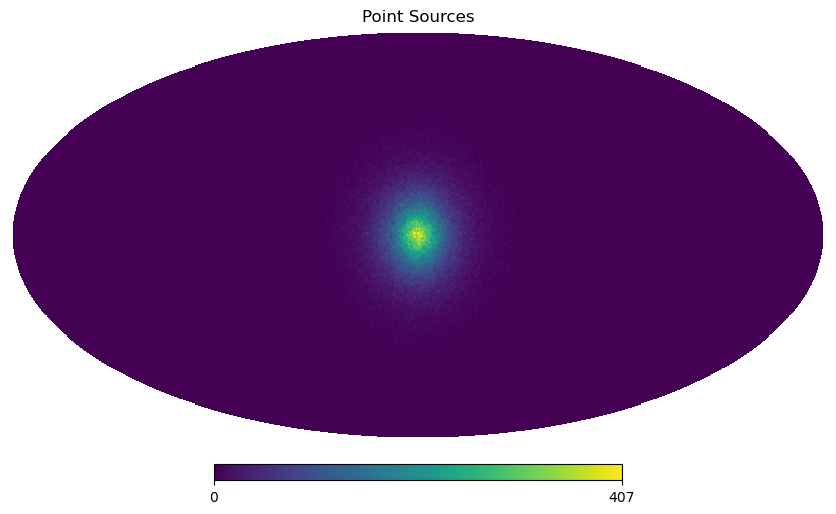

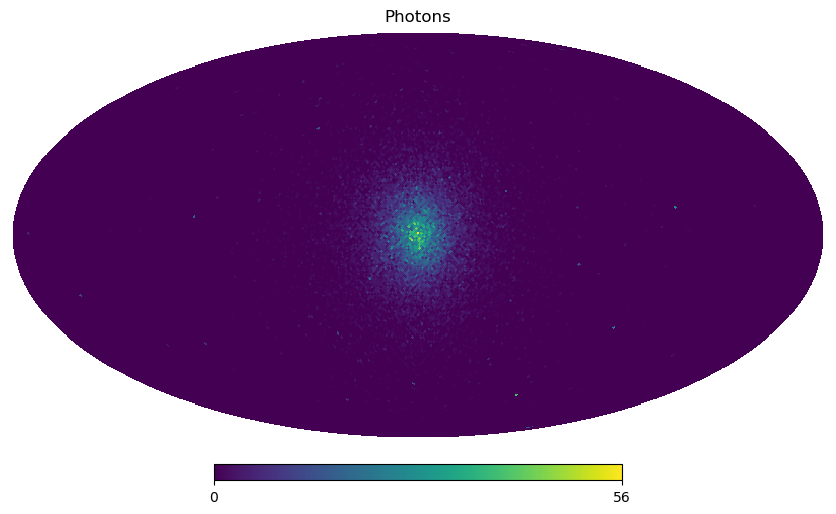

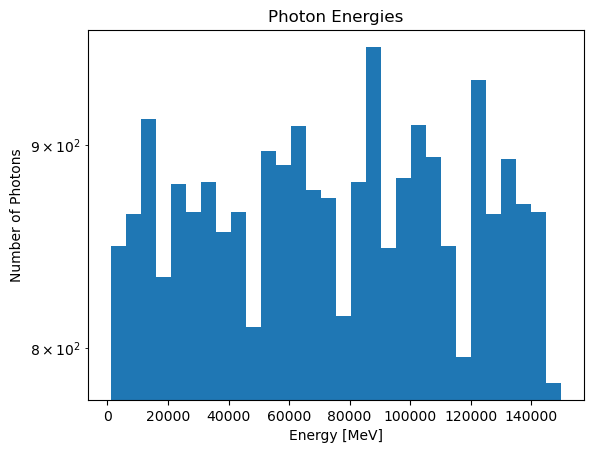

In [6]:
input_params = [10000]

source_info = my_AEGIS.create_sources(input_params, grains = 10000)
photon_info = my_AEGIS.generate_photons_from_sources(input_params, source_info)

N_side = 2**6
heatmap = np.histogram(hp.ang2pix(N_side, source_info['angles'][:,0], source_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
hp.mollview(heatmap[0], title = 'Point Sources')

heatmap = np.histogram(hp.ang2pix(N_side, photon_info['angles'][:,0], photon_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
hp.mollview(heatmap[0], title = 'Photons')

fig, ax = plt.subplots()
ax.set_title('Photon Energies')
ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_ylabel('Number of Photons')
ax.set_xlabel('Energy [MeV]')
ax.hist(photon_info['energies'], bins = 30, range = energy_range_gen)

print('Number of sources: ', np.size(source_info['distances']))
print('Number of photons: ', np.size(photon_info['energies']))
print('Average photon energy: ', np.mean(photon_info['energies'])/1000, ' GeV')
print('Average luminosity/source: ', np.mean(source_info['luminosities'])*np.mean(photon_info['energies'])*u.MeV.to('erg'), r'$ erg s^{-1}$')
print('Approximate Flux: ', np.mean(photon_info['energies'])*u.MeV.to('erg')*np.size(photon_info['energies'])/(exposure*u.yr.to('s')), r'$ erg cm^{-2}s^{-1}$')
print('Size of pixels (deg):', hp.nside2resol(N_side)*u.rad.to('deg'))

Now, let's replace our previous source with a simple independent_cylindrical_single_spectrum source and regenerate the data

In [7]:
def R_c(r, params):
    A = params[0]
    r_s = 3 #kpc
    return A * np.exp(-r/r_s)

def Z_c(z, params):
    z_s = 3 #kpc
    return np.exp(-np.abs(z)/z_s)

def Phi_c(phi, params):
    return np.ones(np.shape(phi))

def L(l, params):
    L_b = 1.56e37/2.35 #photons/s
    return np.exp(-1000*l/L_b)

def spec(energy, params):
    return np.ones(np.size(energy))

als_c = [(R_c, Z_c, Phi_c), L, spec]
my_AEGIS.abun_lum_spec = [als_c]
my_AEGIS.source_class_list = ['independent_cylindrical_single_spectrum']

Number of sources:  3394639
Number of photons:  425229
Average photon energy:  75.37433765105798  GeV
Average luminosity/source:  8.015349118447106e+32 $ erg s^{-1}$
Approximate Flux:  4.0681112336954483e-07 $ erg cm^{-2}s^{-1}$
Size of pixels (deg): 0.9161297098179749


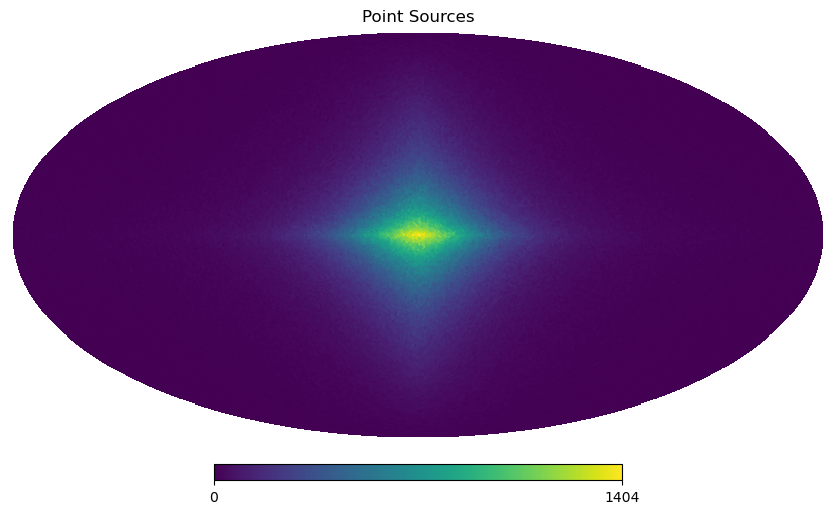

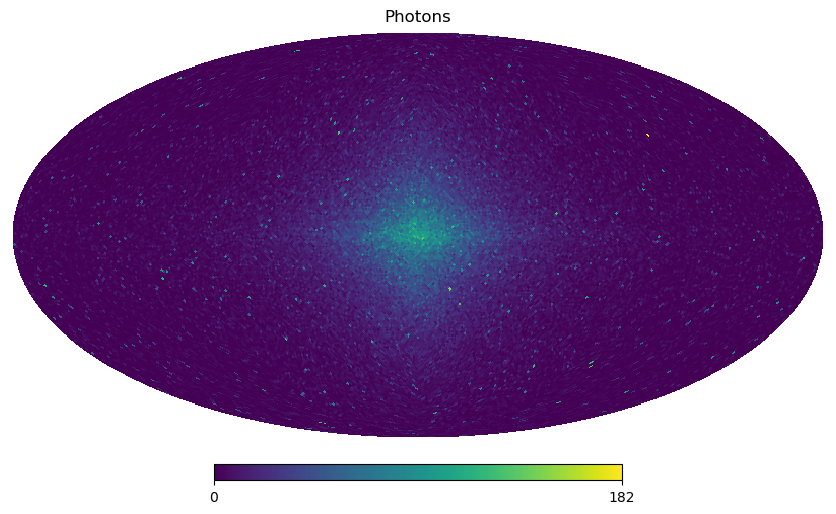

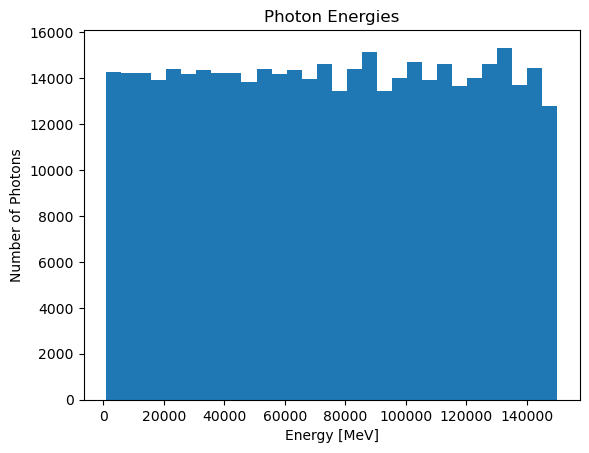

In [8]:
input_params = [10000]

source_info = my_AEGIS.create_sources(input_params, grains = 10000)
photon_info = my_AEGIS.generate_photons_from_sources(input_params, source_info)

N_side = 2**6
heatmap = np.histogram(hp.ang2pix(N_side, source_info['angles'][:,0], source_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
hp.mollview(heatmap[0], title = 'Point Sources')

heatmap = np.histogram(hp.ang2pix(N_side, photon_info['angles'][:,0], photon_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
hp.mollview(heatmap[0], title = 'Photons')

fig, ax = plt.subplots()
ax.set_title('Photon Energies')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_ylabel('Number of Photons')
ax.set_xlabel('Energy [MeV]')
ax.hist(photon_info['energies'], bins = 30, range = energy_range_gen)

print('Number of sources: ', np.size(source_info['distances']))
print('Number of photons: ', np.size(photon_info['energies']))
print('Average photon energy: ', np.mean(photon_info['energies'])/1000, ' GeV')
print('Average luminosity/source: ', np.mean(source_info['luminosities'])*np.mean(photon_info['energies'])*u.MeV.to('erg'), r'$ erg s^{-1}$')
print('Approximate Flux: ', np.mean(photon_info['energies'])*u.MeV.to('erg')*np.size(photon_info['energies'])/(exposure*u.yr.to('s')), r'$ erg cm^{-2}s^{-1}$')
print('Size of pixels (deg):', hp.nside2resol(N_side)*u.rad.to('deg'))

Now, let's instead use a source of the isotropic_faint_single_spectrum type.

In [9]:
def RL(r, l, params):
    A = params[0]
    r_s = 3 #kpc
    L_b = 1.56e37/2.35 #photons/s
    return A * np.exp(-r/r_s) * np.exp(-1e7*l/L_b)

def spec(energy, params):
    return np.ones(np.size(energy))

als_f = [RL, spec]
my_AEGIS.abun_lum_spec = [als_f]
my_AEGIS.source_class_list = ['isotropic_faint_single_spectrum']

Number of sources:  10023255
Number of photons:  237
Average photon energy:  75.30769641242799  GeV
Average luminosity/source:  2.0070924513885722e+29 $ erg s^{-1}$
Approximate Flux:  2.2653439169889963e-10 $ erg cm^{-2}s^{-1}$
Size of pixels (deg): 0.9161297098179749


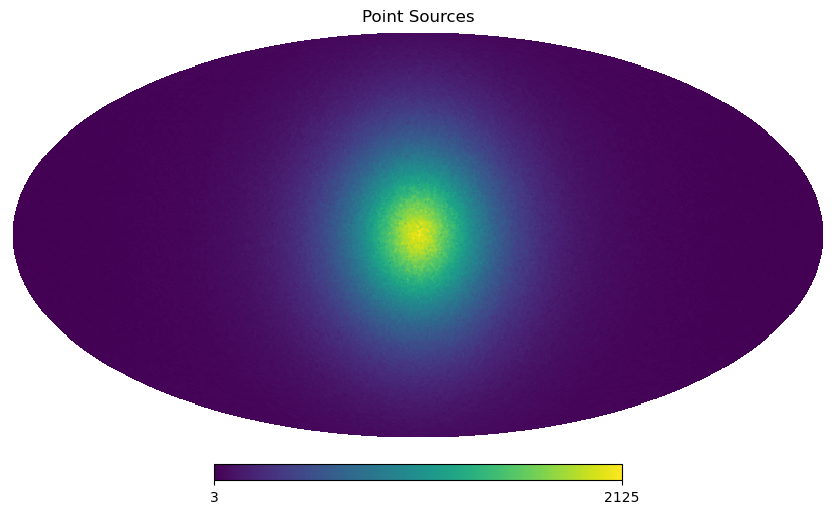

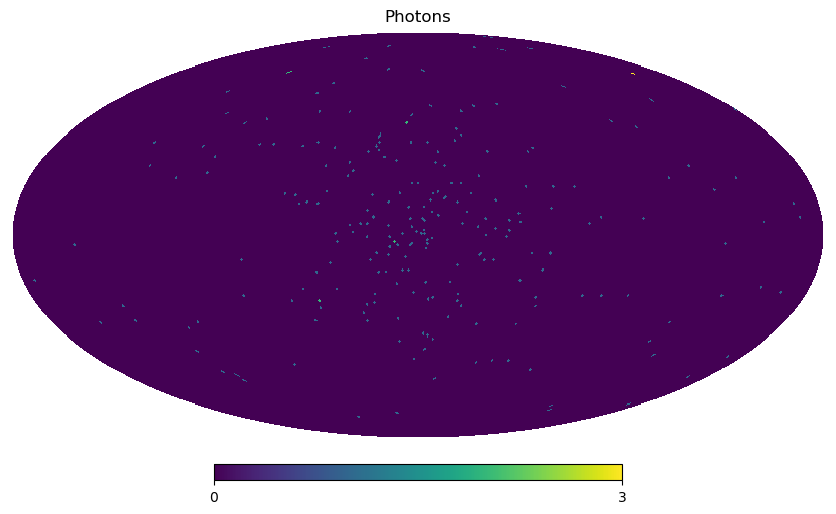

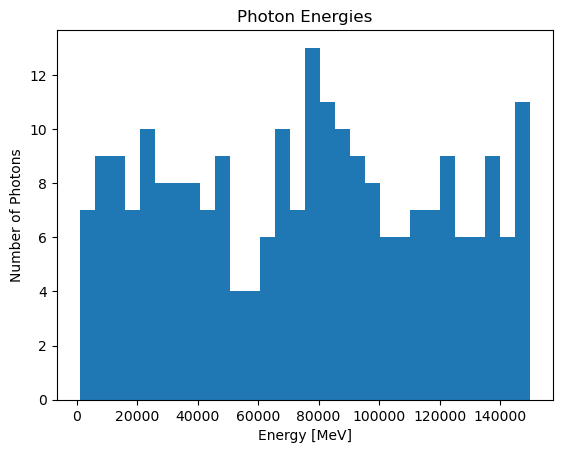

In [10]:
input_params = [1e-25]

source_info = my_AEGIS.create_sources(input_params, grains = 10000)
photon_info = my_AEGIS.generate_photons_from_sources(input_params, source_info)

N_side = 2**6
heatmap = np.histogram(hp.ang2pix(N_side, source_info['angles'][:,0], source_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
hp.mollview(heatmap[0], title = 'Point Sources')

heatmap = np.histogram(hp.ang2pix(N_side, photon_info['angles'][:,0], photon_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
hp.mollview(heatmap[0], title = 'Photons')

fig, ax = plt.subplots()
ax.set_title('Photon Energies')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_ylabel('Number of Photons')
ax.set_xlabel('Energy [MeV]')
ax.hist(photon_info['energies'], bins = 30, range = energy_range_gen)

print('Number of sources: ', np.size(source_info['distances']))
print('Number of photons: ', np.size(photon_info['energies']))
print('Average photon energy: ', np.mean(photon_info['energies'])/1000, ' GeV')
print('Average luminosity/source: ', np.mean(source_info['luminosities'])*np.mean(photon_info['energies'])*u.MeV.to('erg'), r'$ erg s^{-1}$')
print('Approximate Flux: ', np.mean(photon_info['energies'])*u.MeV.to('erg')*np.size(photon_info['energies'])/(exposure*u.yr.to('s')), r'$ erg cm^{-2}s^{-1}$')
print('Size of pixels (deg):', hp.nside2resol(N_side)*u.rad.to('deg'))

Most of the sources we just generated didn't give us any photons. When using a source type that contains 'isotropic_faint', the additional argument of the create_sources function, 'epsilon', can help us. When the expected number of photons from a single source is less than some small epsilon for some R and L bin, the probability of getting n photons is approximately binomial. The probability of 0 photons is large and the probability of > 1 photon is negligible. When 'epsilon' is set to a value greater than it's default of zero, only the sources that give one photon are generated for such faint RL bins. For RL bins wehre the expected number of photons per source is > 'epsilon', sources are generated normally. This method, although an approximation, allows for simulations where the number of photons is physically reasonable, but the large number of faint sources that produced them is computationally intractable to generate. Let's time our simulation for different values of epsilon.

In [11]:
import time

epsilons = [0, 0.001, 0.01]
for epsilon in epsilons:
    start_time = time.time()
    source_info = my_AEGIS.create_sources(input_params, grains = 10000, epsilon = epsilon)
    photon_info = my_AEGIS.generate_photons_from_sources(input_params, source_info)
    end_time = time.time()
    num_s = np.size(source_info['distances'])
    num_sps = np.size(source_info['single_p_distances'])
    num_p = np.size(photon_info['energies'])
    print(f'epsilon: {epsilon}, elapsed time: {np.round(end_time-start_time)}s, number of sources = {num_s}, number of single_p_sources = {num_sps}, number of photons: {num_p}')

epsilon: 0, elapsed time: 149.0s, number of sources = 10023255, number of single_p_sources = 0, number of photons: 263


/home/chri3448/DGRB/aegis.py:151: RuntimeWarning: invalid value encountered in divide
  y_cdfs = np.cumsum(pdf, axis = 1)/np.tile(np.sum(pdf, axis = 1), (np.size(pdf[0,:]),1)).T


epsilon: 0.001, elapsed time: 39.0s, number of sources = 2043868, number of single_p_sources = 159, number of photons: 248
epsilon: 0.01, elapsed time: 25.0s, number of sources = 649804, number of single_p_sources = 216, number of photons: 244


AEGIS can also generate sources at cosmological distances. If using a cosmology, it should be given to the AEGIS upon initialization. So, let's redefine our AEGIS, passing 'static Einstein universe' as our cosmology. The default value for AEGIS.cosmology is None. We also need to specify the end points of the range of z values we want to generate sources between.

In [12]:
my_cosmology = 'static Einstein universe'
z_range = [0, 14]
my_AEGIS = aegis.aegis(abundance_luminosity_and_spectrum_list, source_class_list, parameter_range, energy_range, luminosity_range, max_radius, exposure, angular_cut, lat_cut, flux_cut, cosmology = my_cosmology, z_range = z_range, verbose = False)
my_AEGIS.angular_cut_gen, my_AEGIS.lat_cut_gen, my_AEGIS.Emin_gen, my_AEGIS.Emax_gen = angular_cut_gen, lat_cut_gen, energy_range_gen[0], energy_range_gen[1]

Exception: No valid cosmology given. Try one of these preloaded cosmologies: Planck13, Planck15, Planck18, WMAP1, WMAP3, WMAP5, WMAP7, WMAP9. Alternatively, give a custom cosmology of the astropy.cosmology.FlatLambdaCDM class.

Oops, that wasn't a valid cosmology. Let's try that again, using the cosmology published by the Planck collaboration in 2018.

In [13]:
my_cosmology = 'Planck18'
z_range = [0, 14]
luminosity_range = 10.0**np.array([50, 70])
my_AEGIS = aegis.aegis(abundance_luminosity_and_spectrum_list, source_class_list, parameter_range, energy_range, luminosity_range, max_radius, exposure, angular_cut, lat_cut, flux_cut, cosmology = my_cosmology, z_range = z_range, verbose = False)
my_AEGIS.angular_cut_gen, my_AEGIS.lat_cut_gen, my_AEGIS.Emin_gen, my_AEGIS.Emax_gen = angular_cut_gen, lat_cut_gen, energy_range_gen[0], energy_range_gen[1]

Now that we have an AEGIS with a cosmology, let's generate photons from an extragalactic_isotropic_faint_single_spectrum source type.

In [14]:
def ZL(z, l, params):
    A = params[0]
    z_s = 1e6 #kpc
    L_b = 1e50 #photons/s
    return A * np.exp(-z/z_s) * np.exp(-l/L_b)

def spec(energy, params):
    return np.ones(np.size(energy))

als_ef = [ZL, spec]
my_AEGIS.abun_lum_spec = [als_ef]
my_AEGIS.source_class_list = ['extragalactic_isotropic_faint_single_spectrum']

Number of sources:  1093300
Number of photons:  43250149
Average photon energy:  75.30195789872188  GeV
Average luminosity/source:  2.2352906215073596e+49 $ erg s^{-1}$
Approximate Flux:  4.133712913592315e-05 $ erg cm^{-2}s^{-1}$
Size of pixels (deg): 0.9161297098179749


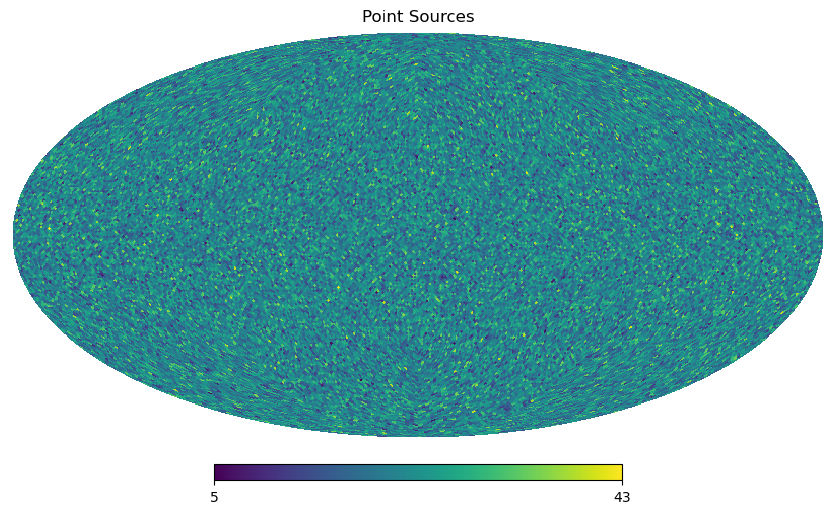

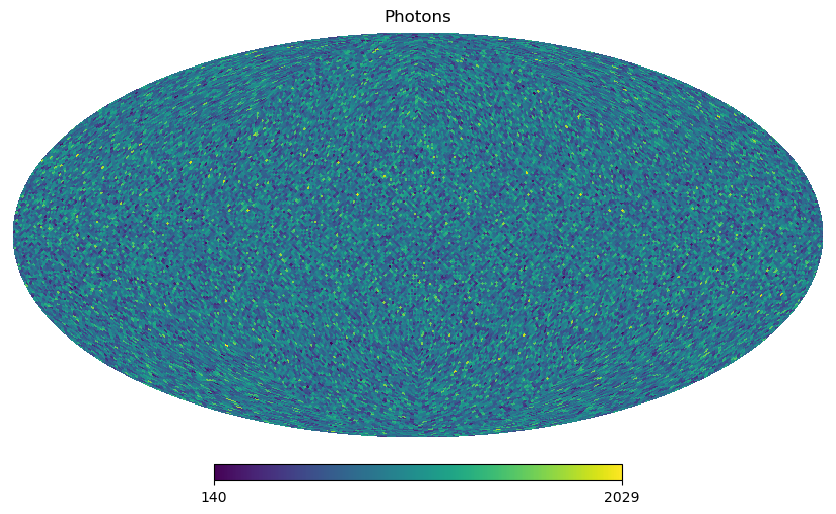

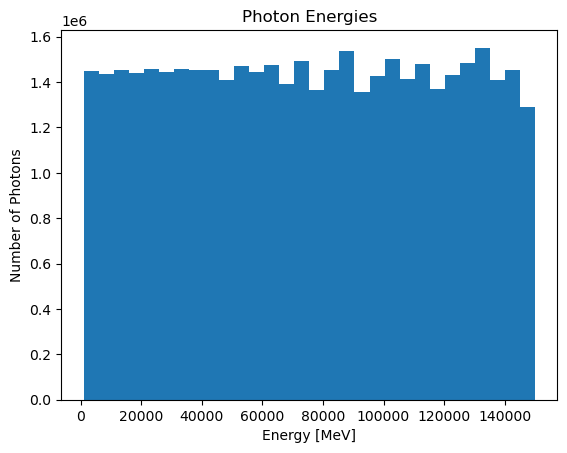

In [15]:
input_params = [1e-65]

source_info = my_AEGIS.create_sources(input_params, grains = 1000)
photon_info = my_AEGIS.generate_photons_from_sources(input_params, source_info)

N_side = 2**6
heatmap = np.histogram(hp.ang2pix(N_side, source_info['angles'][:,0], source_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
hp.mollview(heatmap[0], title = 'Point Sources')

heatmap = np.histogram(hp.ang2pix(N_side, photon_info['angles'][:,0], photon_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
hp.mollview(heatmap[0], title = 'Photons')

fig, ax = plt.subplots()
ax.set_title('Photon Energies')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_ylabel('Number of Photons')
ax.set_xlabel('Energy [MeV]')
ax.hist(photon_info['energies'], bins = 30, range = energy_range_gen)

print('Number of sources: ', np.size(source_info['distances']))
print('Number of photons: ', np.size(photon_info['energies']))
print('Average photon energy: ', np.mean(photon_info['energies'])/1000, ' GeV')
print('Average luminosity/source: ', np.mean(source_info['luminosities'])*np.mean(photon_info['energies'])*u.MeV.to('erg'), r'$ erg s^{-1}$')
print('Approximate Flux: ', np.mean(photon_info['energies'])*u.MeV.to('erg')*np.size(photon_info['energies'])/(exposure*u.yr.to('s')), r'$ erg cm^{-2}s^{-1}$')
print('Size of pixels (deg):', hp.nside2resol(N_side)*u.rad.to('deg'))

AEGIS is configured for FERMI analysis. As such, the FERMI PSF and energy dispersion are built in as defaults. For information on how these are implemented by the FERMI colaboration visit https://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/Cicerone_LAT_IRFs/IRF_overview.html

The methods apply_PSF, apply_energy_dispersion, and apply_exposure should be overwritten if a different observatory framework is used. When generating photons, an isotropic exposure across the sky is assumed. The method apply_exposure takes a healpix map of true exposures across the sky and deletes generated photons stochastically. The exposure used to generate photons should be the maximum of the healpix exposure map.

To begin, a dictionary 'obs_info' must be created, containing the path to the FERMI PSF and energy dispersion FITS files. It must also include the event type and exposure map. More FITS files can be found at https://heasarc.gsfc.nasa.gov/FTP/fermi/calib_data/lat/bcf/

(array([1514313., 1525345., 1540204., 1545776., 1542474., 1542904.,
        1541063., 1547618., 1546090., 1550518., 1550430., 1556681.,
        1548084., 1539060., 1519912., 1520252., 1499488., 1472340.,
        1471816., 1460149., 1428571., 1409035., 1384787., 1318913.,
        1270725., 1208251., 1094211.,  993290.,  817981.,  641255.]),
 array([  1000.        ,   5966.66666667,  10933.33333333,  15900.        ,
         20866.66666667,  25833.33333333,  30800.        ,  35766.66666667,
         40733.33333333,  45700.        ,  50666.66666667,  55633.33333333,
         60600.        ,  65566.66666667,  70533.33333333,  75500.        ,
         80466.66666667,  85433.33333333,  90400.        ,  95366.66666667,
        100333.33333333, 105300.        , 110266.66666667, 115233.33333333,
        120200.        , 125166.66666667, 130133.33333333, 135100.        ,
        140066.66666667, 145033.33333333, 150000.        ]),
 <BarContainer object of 30 artists>)

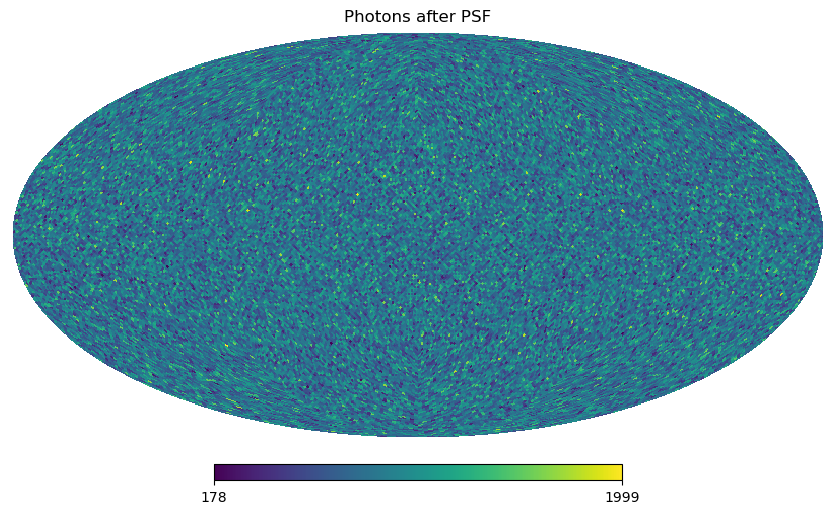

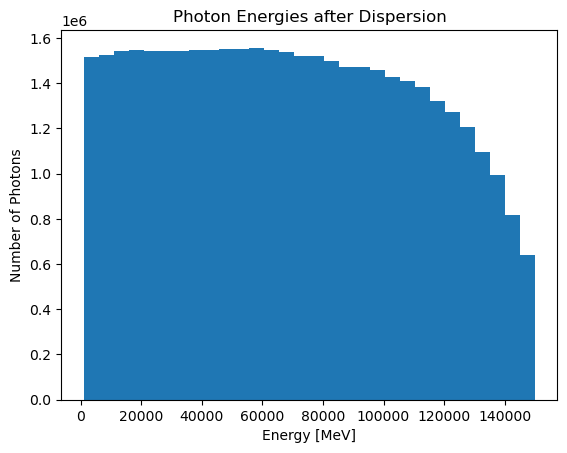

In [16]:
obs_info = {'psf_fits_path': 'FERMI_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': 'FERMI_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}

obs_photon_info = my_AEGIS.apply_exposure(photon_info, obs_info)
obs_photon_info = my_AEGIS.apply_PSF(obs_photon_info, obs_info)
obs_photon_info = my_AEGIS.apply_energy_dispersion(obs_photon_info, obs_info)

heatmap = np.histogram(hp.ang2pix(N_side, obs_photon_info['angles'][:,0], obs_photon_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
hp.mollview(heatmap[0], title = 'Photons after PSF')

fig, ax = plt.subplots()
ax.set_title('Photon Energies after Dispersion')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_ylabel('Number of Photons')
ax.set_xlabel('Energy [MeV]')
ax.hist(obs_photon_info['energies'], bins = 30, range = energy_range_gen)

AEGIS contains built in features for applying simple masks. This includes a latitude cut 'lat_cut', which obscures everything within 'lat_cut' radians of the galactic plane. There is also an angular cut 'angular_cut', which obscures everything with a larger angular separation from the galactic center than 'angular_cut'. There is also an energy cut given by 'energy_range'. All of these settings have corresponding settings with a '_gen' suffix, which control out to what values the sources and photons are initially generated. This is to allow for photons to spread across the borders of the masks before the masks are applied. AEGIS used these _gen cuts to efficiently generate sources and data only where necessary. Let's set some of these cuts and apply them with the apply_mask method.

(array([6851., 8730., 8858., 8812., 8866., 8751., 8861., 8880., 8798.,
        8673., 8914., 8815., 8842., 8603., 8746., 8536., 8651., 8265.,
        8380., 7674.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.]),
 array([  1000.        ,   5966.66666667,  10933.33333333,  15900.        ,
         20866.66666667,  25833.33333333,  30800.        ,  35766.66666667,
         40733.33333333,  45700.        ,  50666.66666667,  55633.33333333,
         60600.        ,  65566.66666667,  70533.33333333,  75500.        ,
         80466.66666667,  85433.33333333,  90400.        ,  95366.66666667,
        100333.33333333, 105300.        , 110266.66666667, 115233.33333333,
        120200.        , 125166.66666667, 130133.33333333, 135100.        ,
        140066.66666667, 145033.33333333, 150000.        ]),
 <BarContainer object of 30 artists>)

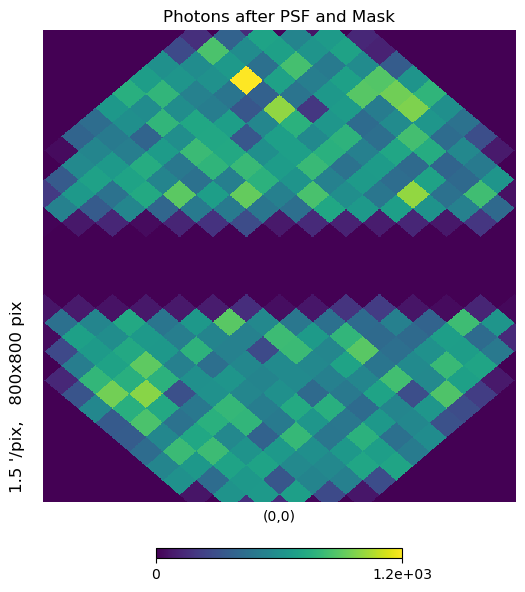

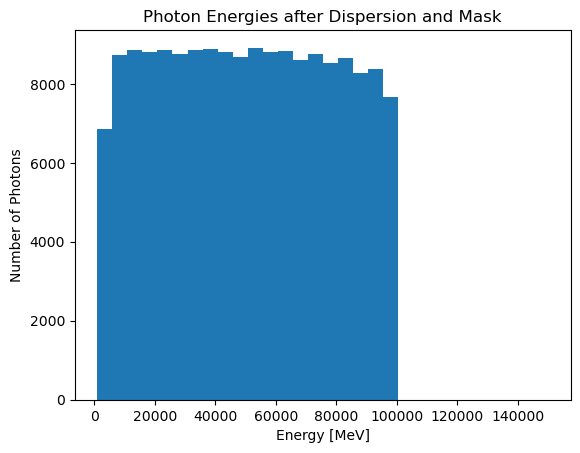

In [17]:
angular_cut = 10*u.deg.to('rad') #degrees
lat_cut = 2*u.deg.to('rad') #degrees
energy_range = [2000, 100000] #MeV
my_AEGIS.angular_cut_mask = angular_cut
my_AEGIS.lat_cut_mask = lat_cut
my_AEGIS.Emin_mask = energy_range[0]
my_AEGIS.Emax_mask = energy_range[1]
my_AEGIS.angular_cut_gen, my_AEGIS.lat_cut_gen, my_AEGIS.Emin_gen, my_AEGIS.Emax_gen = angular_cut_gen, lat_cut_gen, energy_range_gen[0], energy_range_gen[1]

obs_photon_info = my_AEGIS.apply_mask(obs_photon_info, obs_info)

heatmap = np.histogram(hp.ang2pix(N_side, obs_photon_info['angles'][:,0], obs_photon_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
hp.gnomview(heatmap[0], title = 'Photons after PSF and Mask', xsize = int(round(2*angular_cut*u.rad.to('arcmin')/1.5)), reso = 1.5)

fig, ax = plt.subplots()
ax.set_title('Photon Energies after Dispersion and Mask')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_ylabel('Number of Photons')
ax.set_xlabel('Energy [MeV]')
ax.hist(obs_photon_info['energies'], bins = 30, range = energy_range_gen)

All four of these observation methods are wrapped into a silgle method 'mock_observe' that is best used in practice.

(array([6899., 8774., 9004., 8845., 8969., 8854., 8810., 8924., 8791.,
        8951., 8833., 8923., 9016., 8812., 8742., 8621., 8552., 8433.,
        8388., 7620.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.]),
 array([  1000.        ,   5966.66666667,  10933.33333333,  15900.        ,
         20866.66666667,  25833.33333333,  30800.        ,  35766.66666667,
         40733.33333333,  45700.        ,  50666.66666667,  55633.33333333,
         60600.        ,  65566.66666667,  70533.33333333,  75500.        ,
         80466.66666667,  85433.33333333,  90400.        ,  95366.66666667,
        100333.33333333, 105300.        , 110266.66666667, 115233.33333333,
        120200.        , 125166.66666667, 130133.33333333, 135100.        ,
        140066.66666667, 145033.33333333, 150000.        ]),
 <BarContainer object of 30 artists>)

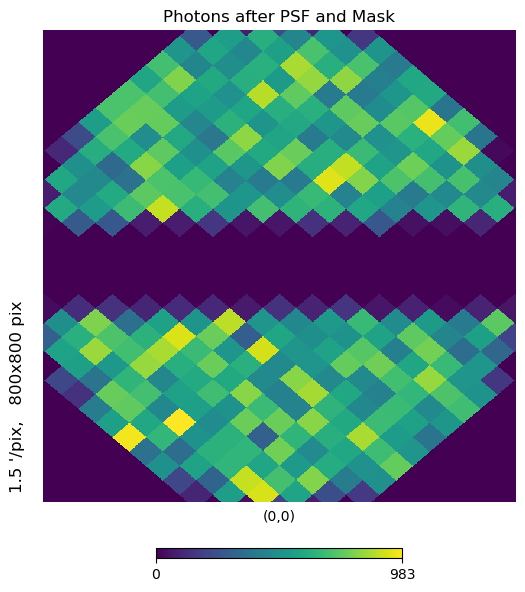

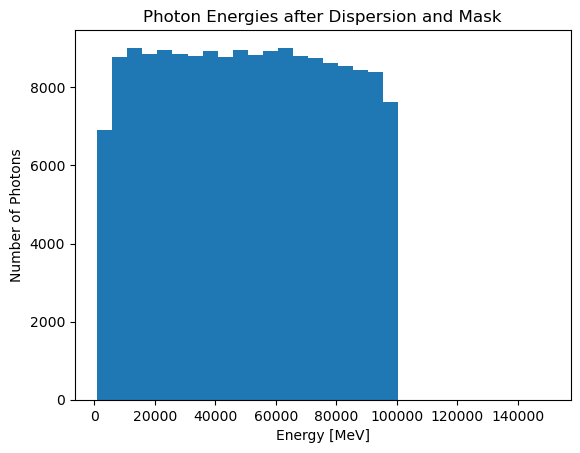

In [18]:
source_info = my_AEGIS.create_sources(input_params, grains = 1000)
photon_info = my_AEGIS.generate_photons_from_sources(input_params, source_info)
obs_photon_info = my_AEGIS.mock_observe(photon_info, obs_info)

heatmap = np.histogram(hp.ang2pix(N_side, obs_photon_info['angles'][:,0], obs_photon_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
hp.gnomview(heatmap[0], title = 'Photons after PSF and Mask', xsize = int(round(2*angular_cut*u.rad.to('arcmin')/1.5)), reso = 1.5)

fig, ax = plt.subplots()
ax.set_title('Photon Energies after Dispersion and Mask')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_ylabel('Number of Photons')
ax.set_xlabel('Energy [MeV]')
ax.hist(obs_photon_info['energies'], bins = 30, range = energy_range_gen)